# Stock analysis

## Import

Libraries

In [1]:
from utils.init import *

from utils.analyse_price import *
from utils.analyse_fundementals import *
from utils.data import *
from utils.params import *

In [2]:
TICKER = 'TWE'
COUNTRY = 'AU'
first_end_of_quarter = '2020-06'
last_end_of_quarter = '2024-06'
historical_prices_dict = {}

## Get data

Run data

In [3]:
# read in data
interest_rate_df_dict = get_interest_rate(COUNTRY)
if COUNTRY == 'AU':
    asx_companies_directory_df = get_asx_companies_directory()
    asx_gics_df = get_asx_gics()

# get same gics tickers
if COUNTRY == 'AU':
    AU_top_list_dict = get_top_ASX_companies_list(asx_companies_directory_df)
    ASX_ticker_gics_dict = get_ASX_ticker_gics(TICKER, asx_gics_df)
    same_gics_ASX_tickers_dict = get_same_gics_ASX_tickers(asx_gics_df,
                                                        ASX_ticker_gics_dict, AU_top_list_dict)
    comparable_ASX_tickers_dict = get_comparable_ASX_tickers(
        TICKER, same_gics_ASX_tickers_dict)
    
    print(comparable_ASX_tickers_dict['type'])
    
    same_industry_ASX_tickers_mcap_df = get_same_gics_ASX_MCap_weights(TICKER,
                                                                   asx_companies_directory_df, comparable_ASX_tickers_dict)
    
# market value and weight
if COUNTRY == 'AU':
    same_industry_tickers_mcap_df = get_same_industry_tickers_mcap(
    same_industry_ASX_tickers_mcap_df)
    display(same_industry_tickers_mcap_df)
    
    ticker_mv_df = get_AU_ticker_mv_df(asx_companies_directory_df, TICKER)
    display(ticker_mv_df)

    ticker_proportion_of_market = get_AU_ticker_proportion_of_market(
        ticker_mv_df, same_industry_tickers_mcap_df)
    print(round(ticker_proportion_of_market, 2))
    
    plot_gics_mcap_weights(TICKER, same_industry_tickers_mcap_df)
    
    same_gics_industry_weight_dict = get_same_AU_gics_industry_weight_dict(
    same_industry_tickers_mcap_df)
    
# TODO: should be able to not need comparable_ASX_ticker_dict
analysis_needed_ticker_list = get_analysis_needed_ticker_list(
    TICKER, comparable_ASX_tickers_dict, index_tickers_list)
historical_prices_dict = get_historical_prices_for_interested_list(
    analysis_needed_ticker_list, index_tickers_list, historical_prices_dict)


In [16]:
monthly_returns_df_dict = {}
for ticker, price_df in historical_prices_dict.items():
    monthly_returns_df_dict[ticker] = get_return(
        price_df, interest_rate_df_dict['monthly'], 'M')

quarterly_returns_df_dict = {}
for ticker, price_df in historical_prices_dict.items():
    quarterly_returns_df_dict[ticker] = get_return(
        price_df, interest_rate_df_dict['quarterly'], 'Q')

yearly_returns_df_dict = {}
for ticker, price_df in historical_prices_dict.items():
    yearly_returns_df_dict[ticker] = get_return(
        price_df, interest_rate_df_dict['annualy'], 'Y')

In [17]:
# ASX ONLY

monthly_returns_df_dict = get_gics_industry_weighted_mean(
    monthly_returns_df_dict, TICKER, analysis_needed_ticker_list, same_gics_industry_weight_dict, index_tickers_list, 'M', comparable_tickers=comparable_ASX_tickers_dict)
quarterly_returns_df_dict = get_gics_industry_weighted_mean(
    quarterly_returns_df_dict, TICKER, analysis_needed_ticker_list, same_gics_industry_weight_dict, index_tickers_list, 'Q', comparable_tickers=comparable_ASX_tickers_dict)
yearly_returns_df_dict = get_gics_industry_weighted_mean(
    yearly_returns_df_dict, TICKER, analysis_needed_ticker_list, same_gics_industry_weight_dict, index_tickers_list, 'Y', comparable_tickers=comparable_ASX_tickers_dict)

In [18]:
get_monthly_stats(monthly_returns_df_dict, TICKER,
                  first_end_of_quarter, last_end_of_quarter)

{'mean (%)': 1.0,
 'std (%)': 7.17,
 'mean (-rf) (%)': 0.77,
 'std (-rf) (%)': 7.18,
 'n': 49,
 'sharpe': 0.37,
 'CAPM beta': 0.45,
 'CAPM alpha': -0.15}

In [19]:
stats_dict = {}

for ticker in monthly_returns_df_dict:
    stats_dict[ticker] = get_monthly_stats(
        monthly_returns_df_dict, ticker, first_end_of_quarter, last_end_of_quarter)

stats_df = pd.DataFrame(stats_dict).T

In [20]:
stats_df = get_stats_df(TICKER, stats_df, comparable_ASX_tickers_dict,
                        index_tickers_list, same_industry_tickers_mcap_df)

In [21]:
stats_df

,mean (%),std (%),mean (-rf) (%),std (-rf) (%),n,sharpe,CAPM beta,CAPM alpha
TWE,1.00,7.17,0.77,7.18,49.0,0.37,0.45,-0.15
EDV,-0.17,5.73,-0.44,5.75,36.0,-0.27,0.58,-0.59
^AXJO,0.69,3.84,0.46,3.85,49.0,0.41,0.97,-0.03
^AXKO,0.68,3.87,0.46,3.88,49.0,0.41,0.98,-0.03
^AXSO,0.35,5.03,0.13,5.04,49.0,0.09,1.18,-0.18
^AORD,0.71,3.92,0.49,3.93,49.0,0.43,1.00,0.00
GICS I.WMean,-0.17,5.73,-0.44,5.75,36.0,-0.27,0.58,-0.59
GICS I.WMean (Macro),-0.17,5.73,-0.44,5.75,36.0,-0.27,0.58,-0.59


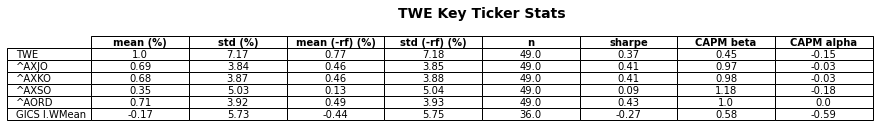

In [22]:
plot_key_ticker_stats_table(stats_df, TICKER, comparable_ASX_tickers_dict)

In [23]:
correlation_df, period_of_interest_return_df = historical_corr(
    monthly_returns_df_dict, first_end_of_quarter, last_end_of_quarter)

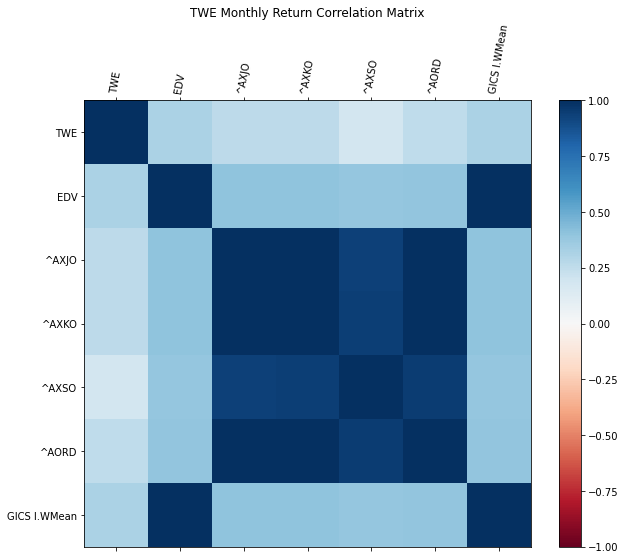

In [24]:
plot_correlation(correlation_df, ticker=TICKER)

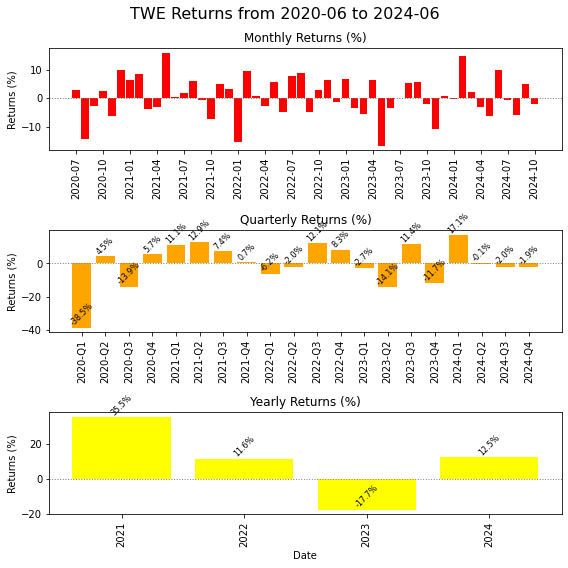

In [25]:
plot_returns(**{'monthly_returns_df_dict': monthly_returns_df_dict,
                'quarterly_returns_df_dict': quarterly_returns_df_dict,
                'yearly_returns_df_dict': yearly_returns_df_dict, 'ticker': TICKER,
                'first_end_of_quarter': first_end_of_quarter,
                'last_end_of_quarter': last_end_of_quarter})

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

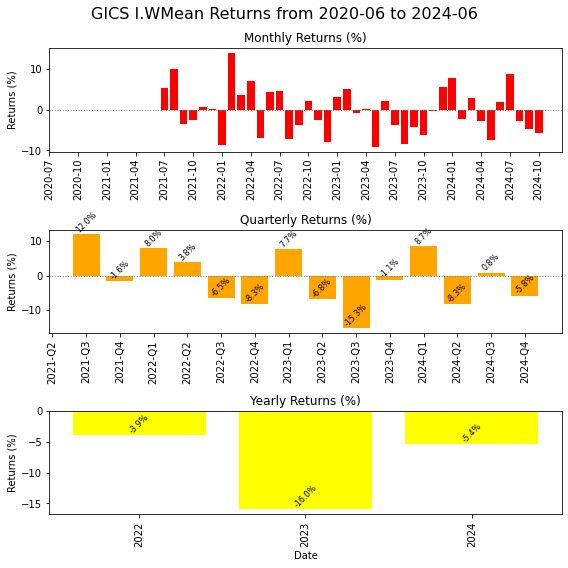

In [26]:
plot_returns(**{'monthly_returns_df_dict': monthly_returns_df_dict,
                'quarterly_returns_df_dict': quarterly_returns_df_dict,
                'yearly_returns_df_dict': yearly_returns_df_dict,
                'ticker': 'GICS I.WMean' if 'industry' in comparable_ASX_tickers_dict['type'] else 'GICS S.WMean',
                'first_end_of_quarter': first_end_of_quarter,
                'last_end_of_quarter': last_end_of_quarter,
                'underlying_ticker': TICKER})

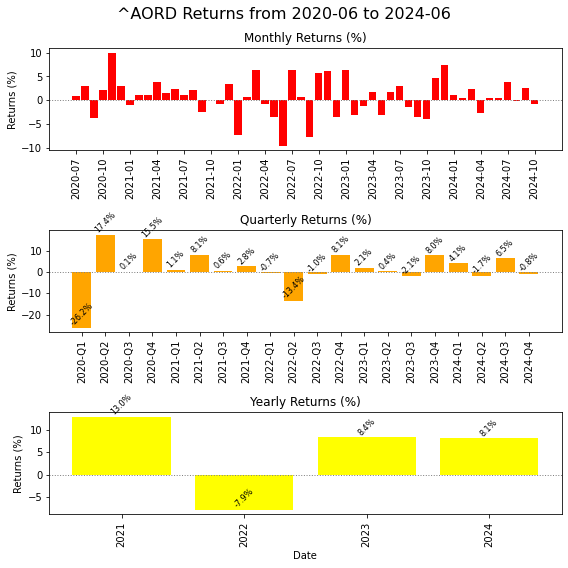

In [27]:
plot_returns(**{'monthly_returns_df_dict': monthly_returns_df_dict,
                'quarterly_returns_df_dict': quarterly_returns_df_dict,
                'yearly_returns_df_dict': yearly_returns_df_dict, 'ticker': '^AORD',
                'first_end_of_quarter': first_end_of_quarter,
                'last_end_of_quarter': last_end_of_quarter})

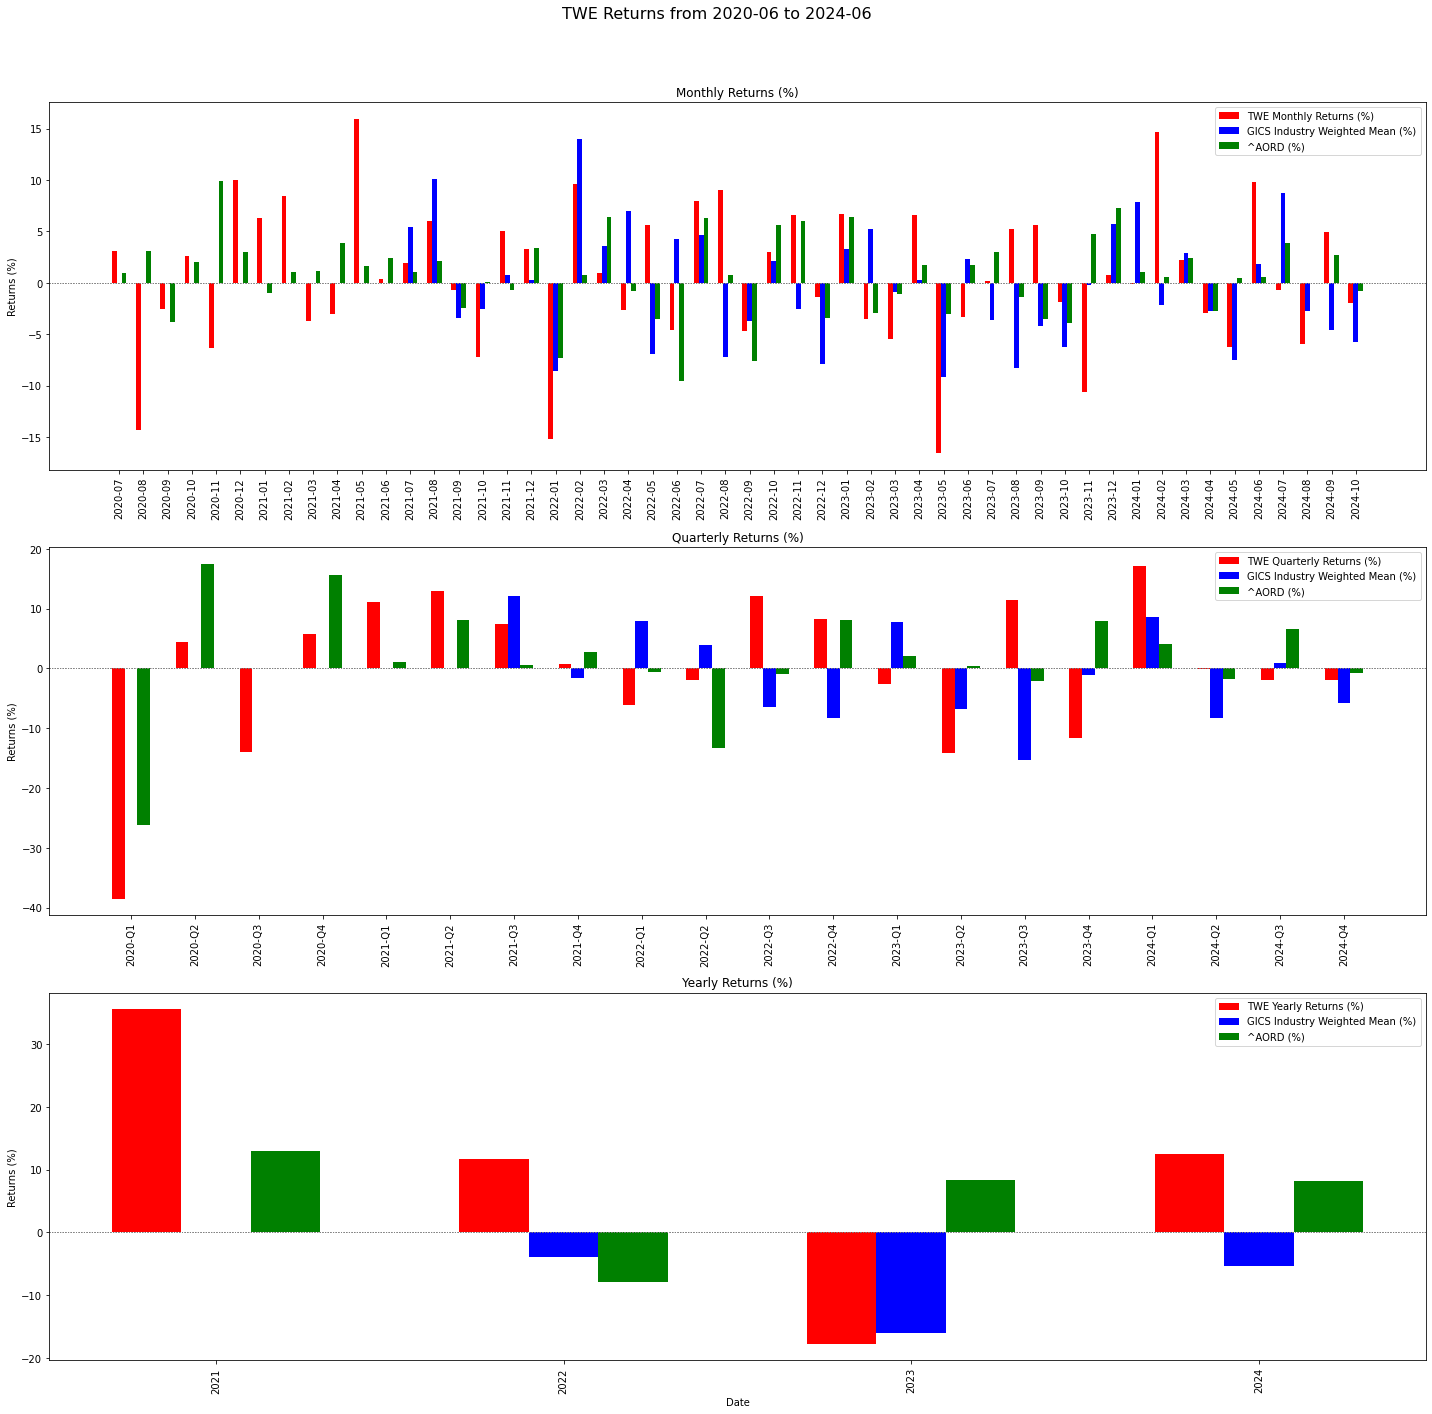

In [28]:
plot_returns_comparative(**{'monthly_returns_df_dict': monthly_returns_df_dict,
                            'quarterly_returns_df_dict': quarterly_returns_df_dict,
                            'yearly_returns_df_dict': yearly_returns_df_dict, 'TICKER': TICKER,
                            'first_end_of_quarter': first_end_of_quarter,
                            'last_end_of_quarter': last_end_of_quarter,
                            'comparable_tickers': comparable_ASX_tickers_dict})

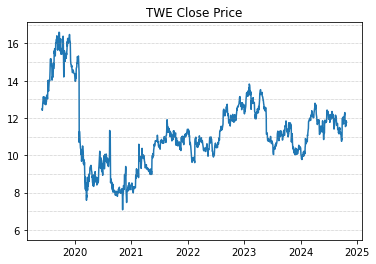

In [29]:
plot_close_price_with_dollar_lines(TICKER, historical_prices_dict)

In [30]:
historical_dividends = get_historical_dividends(TICKER, historical_prices_dict)
historical_dividends

,Date,Dividends
66,2019-09-04,0.197944
191,2020-03-04,0.197944
318,2020-09-02,0.079178
443,2021-03-03,0.148458
570,2021-09-01,0.128663
695,2022-03-02,0.148458
821,2022-08-31,0.158355
948,2023-03-03,0.178149
1073,2023-08-31,0.168252
1203,2024-03-06,0.170000


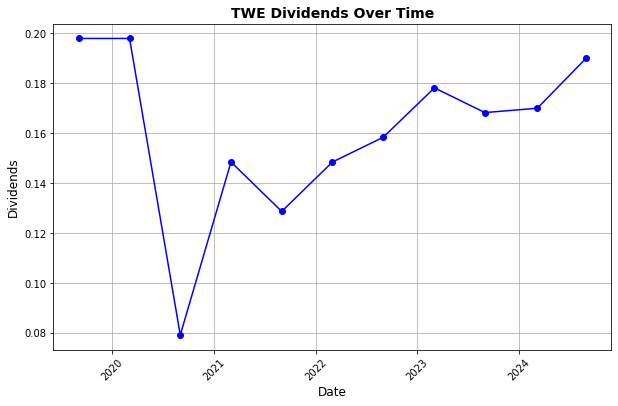

In [31]:
plot_dividends_over_time(TICKER, historical_prices_dict)

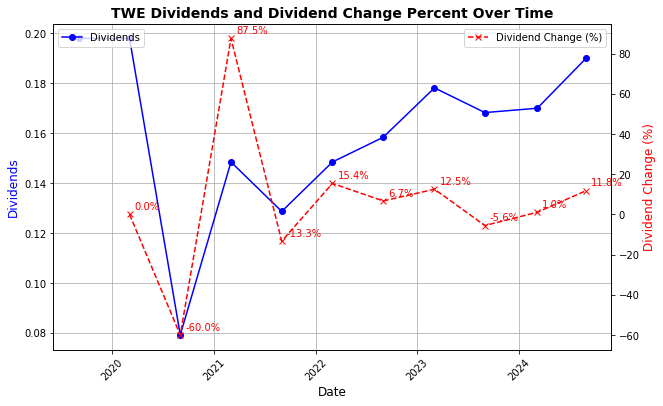

In [32]:
plot_dividends(TICKER, historical_dividends, historical_prices_dict)

In [33]:
historical_splits = get_historical_splits(TICKER, historical_prices_dict)
historical_splits

,Date,Stock Splits


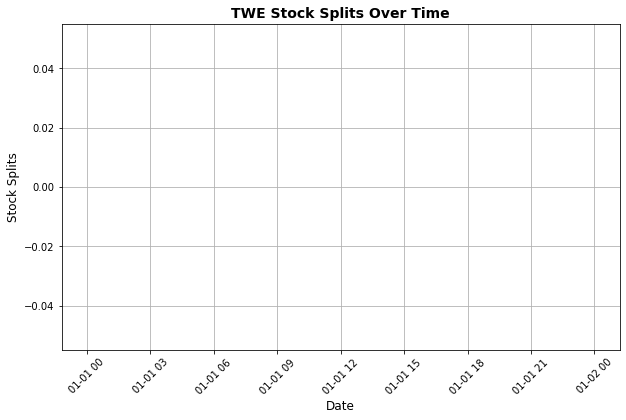

In [34]:
plot_splits_over_time(TICKER, historical_prices_dict)

In [35]:
# pdf = FPDF()

# # TITLE
# # Add a page
# pdf.add_page()
# # Set font for the title
# pdf.set_font("Arial", 'B', 16)  # Bold and size 16 for the title
# title = f"Stock Analysis of Ticker: {TICKER}"
# pdf.cell(200, 10, txt=title, ln=True, align='C')

# # Comparable Ticker Universe
# # Set font for the content
# pdf.set_font("Arial", 'B', size=12)
# pdf.cell(200, 10, txt=f"Comparable tickers universe", ln=True, align='L')
# pdf.set_font("Arial", size=10)
# text = f"{'same INDUSTRY of TOP500' if 'industry' in comparable_tickers['type'] else 'same SECTOR of MCAP$1BN+'}"
# pdf.cell(200, 10, txt=text, ln=True, align='L')

# # Retrieve and convert the Market Cap of the stock in question (from ticker_mv) to billions
# ticker_market_cap_billion = round(
#     ticker_mv.iloc[0]['Market Cap ($bn)'], 2)
# ticker_proportion_of_market = ticker_mv['Market Cap ($bn)'].values[0] / \
#     same_industry_tickers_mcap['Market Cap ($bn)'].sum()
# universe_market_value_billion = round(
#     same_industry_tickers_mcap['Market Cap ($bn)'].sum(), 2)
# pdf.cell(
#     200, 10, txt=f"{TICKER} has a market value of ${ticker_market_cap_billion}B and is {round(ticker_proportion_of_market, 2)} times the universe market value of ${universe_market_value_billion}B,", align='L')
# pdf.cell(
#     200, 10, txt=f"{round(ticker_mv['Market Cap ($bn)'].values[0]/weighted_mean_df['Market Cap ($bn)'].values[0],2)} times the average stock MCap in the universe.", align='L')
# pdf.ln()

# # KEY STATS
# pdf.set_font("Arial", 'B', 12)  # Optional: Add a title before the image
# pdf.cell(200, 10, txt=f"{TICKER} Key Stats", ln=True, align='L')
# pdf.ln(5)  # Line break before adding the image
# pdf.image(
#     f'../outputs/{TICKER}_key_ticker_stats_table.png', x=10, y=None, w=125)

# # COMPARATIVE RETURNS PLOTS
# pdf.set_font("Arial", 'B', 12)  # Optional: Add a title before the image
# pdf.cell(200, 10, txt=f"{TICKER} Comparative Returns Plot", ln=True, align='L')
# pdf.ln(5)  # Line break before adding the image
# pdf.image(f'../outputs/{TICKER}_comparative_returns.png', x=10, y=None, w=150)

# # TICKER RETURN CHART
# pdf.add_page()  # Add a new page for the plot
# pdf.set_font("Arial", 'B', 12)  # Optional: Add a title before the image
# pdf.cell(200, 10, txt=f"{TICKER} Returns Chart", ln=True, align='L')
# pdf.ln(5)  # Line break before adding the image
# pdf.image(f'../outputs/{TICKER}_returns.png', x=10, y=None, w=100)

# # SECTOR/INDUSTRY WMEAN RETURNS CHART
# pdf.set_font("Arial", 'B', 12)  # Optional: Add a title before the image
# pdf.cell(
#     200, 10, txt=f"{TICKER} {'Industry' if 'industry' in comparable_tickers['type'] else 'Sector'} Weighted Mean Returns Chart", ln=True, align='L')
# pdf.ln(5)  # Line break before adding the image
# pdf.image(f'../outputs/{TICKER}_WMean_returns.png', x=10, y=None, w=100)

# # ^AORD CHART
# pdf.add_page()
# pdf.set_font("Arial", 'B', 12)
# pdf.cell(
#     200, 10, txt=f"{TICKER} ^AORD Chart", ln=True, align='L')
# pdf.ln(5)  # Line break before adding the image
# pdf.image(f'../outputs/^AORD_returns.png', x=10, y=None, w=100)

# # CLOSE PRICE CHART
# pdf.add_page()  # Add a new page for the plot
# pdf.set_font("Arial", 'B', 12)  # Optional: Add a title before the image
# pdf.cell(200, 10, txt=f"{TICKER} Close Price Chart", ln=True, align='L')
# pdf.ln(5)  # Line break before adding the image
# pdf.image(f'../outputs/{TICKER}_close_price.png', x=10, y=None, w=75)

# # DIVIDENDS
# pdf.set_font("Arial", 'B', 12)  # Optional: Add a title before the image
# pdf.cell(200, 10, txt=f"{TICKER} Dividends", ln=True, align='L')
# pdf.ln(5)  # Line break before adding the image
# pdf.image(f'../outputs/{TICKER}_dividends_over_time.png', x=10, y=None, w=75)

# # APPENDIX
# pdf.add_page()  # Add a new page for the appendix
# # Set font for the title
# pdf.set_font("Arial", 'B', 12)  # Bold and size 16 for the title

# # APPENDIX TITLE
# title = f"Appendix"
# pdf.cell(200, 10, txt=title, ln=True, align='C')

# # CORRELATION
# pdf.set_font("Arial", 'B', 12)
# pdf.cell(200, 10, txt=f"{TICKER} Correlation Matrix Plot", ln=True, align='L')
# pdf.ln(5)  # Line break before adding the image
# pdf.image(f'../outputs/{TICKER}_correlation_matrix.png', x=10, y=None, w=140)

# # SPLITS
# pdf.set_font("Arial", 'B', 12)
# pdf.cell(200, 10, txt=f"{TICKER} Splits", ln=True, align='L')
# pdf.ln(5)  # Line break before adding the image
# pdf.image(
#     f'../outputs/{TICKER}_stock_splits_over_time.png', x=10, y=None, w=75)

# # INDUSTRY TICKER MCAP TABLE
# pdf.add_page()
# pdf.set_font("Arial", 'B', 12)  # Optional: Add a title before the image
# pdf.cell(
#     200, 10, txt=f"{TICKER} Same {'Industry' if 'industry' in comparable_tickers['type'] else 'Sector'} Ticker MCAP Table", ln=True, align='L')
# pdf.ln(5)  # Line break before adding the image
# pdf.image(
#     f'../outputs/{TICKER}_same_industry_tickers_mcap_table.png', x=10, y=None, w=75)

# # Save the PDF after adding the image
# pdf.output(f"../reports/{TICKER}_comparable_tickers_report_with_plot.pdf")

# Other Stats

In [36]:
interested_ticker_raw_stats, interested_ticker_key_interested_stats, interested_ticker_key_interested_stats_pct_change, object = get_fundemental_dfs(
    first_end_of_quarter, historical_prices_dict, TICKER)

In [37]:
interested_ticker_raw_stats

,Total Debt,Stockholders Equity,Share Issued,Current Liabilities,Current Assets,Free Cash Flow,Interest Paid Supplemental Data,Income Tax Paid Supplemental Data,EBITDA,EBIT,Gross Profit,Operating Expense,Net Income,Total Revenue,Interest Expense,Net Profit,Average Shareholder Equity,Total Asset,Last Close Price,Dividends
2020-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.239538,NaN
2021-06-30,1527800000.0,3587100000.0,729346698.0,878500000.0,2057300000.0,350500000.0,72300000.0,118400000.0,615300000.0,464600000.0,910400000.0,744200000.0,250000000.0,2569600000.0,106900000.0,-24500000.0,3.587100e+09,4465600000.0,10.535044,0.227636
2022-06-30,1673700000.0,3784900000.0,729346698.0,1003100000.0,1989700000.0,449800000.0,66900000.0,95500000.0,644400000.0,495800000.0,988200000.0,747600000.0,263200000.0,2476700000.0,122900000.0,78200000.0,3.686000e+09,4788000000.0,10.478665,0.277121
2023-06-30,1937600000.0,3861700000.0,729346698.0,1098400000.0,2237200000.0,23000000.0,73800000.0,69800000.0,651000000.0,489300000.0,1009300000.0,826600000.0,254500000.0,2423000000.0,152300000.0,39100000.0,3.823300e+09,4960100000.0,10.632826,0.336504
2024-06-30,2158500000.0,4593800000.0,811426445.0,1030500000.0,2188600000.0,241600000.0,111300000.0,31200000.0,528900000.0,373400000.0,1166100000.0,1123500000.0,98900000.0,2739800000.0,205100000.0,-99900000.0,4.227750e+09,5624300000.0,12.241378,0.338252


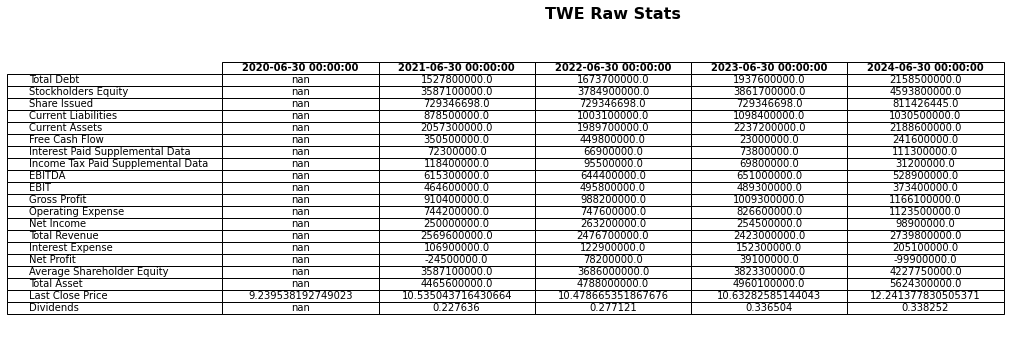

In [38]:
# Create the plot for the table
fig, ax = plt.subplots(figsize=(14, 6))  # Adjust the figure size as needed
ax.axis('tight')
ax.axis('off')

# Create a table in the plot
table = ax.table(cellText=interested_ticker_raw_stats.T.values,
                 colLabels=interested_ticker_raw_stats.T.columns,
                 rowLabels=interested_ticker_raw_stats.T.index,
                 cellLoc='center', loc='center')

# Bold the header row
for key, cell in table.get_celld().items():
    if key[0] == 0:  # This selects the header row
        cell.set_text_props(fontweight='bold')

# Set the title with bold font
plt.title(f"{TICKER} Raw Stats", fontsize=16, fontweight='bold')

# Save the plot as an image
plt.savefig(
    f'../outputs/{TICKER}_interested_ticker_raw_stats.png', bbox_inches='tight', dpi=300)

# Optionally display the plot
plt.show()

In [39]:
interested_ticker_key_interested_stats

,Net Profit Margin,Net Income Margin,RoE,RoA,P/E,P/B,D/E,Current Ratio,Interest Coverage Ratio,DPS
2020-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-06-30,-0.01,0.10,-0.01,-0.01,30.73,2.14,0.43,2.34,6.43,0.23
2022-06-30,0.03,0.11,0.02,0.02,29.04,2.02,0.44,1.98,7.41,0.28
2023-06-30,0.02,0.11,0.01,0.01,30.47,2.01,0.50,2.04,6.63,0.34
2024-06-30,-0.04,0.04,-0.02,-0.02,100.43,2.16,0.47,2.12,3.35,0.34


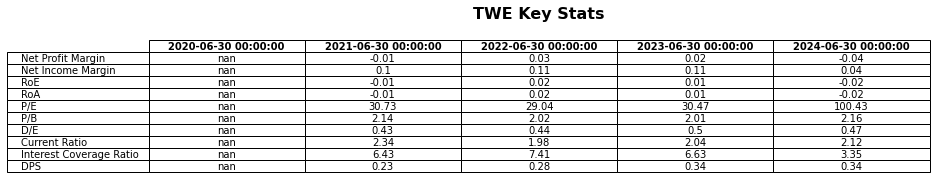

In [40]:
# Create the plot for the table
fig, ax = plt.subplots(figsize=(14, 3))  # Adjust the figure size as needed
ax.axis('tight')
ax.axis('off')

# Create a table in the plot
table = ax.table(cellText=interested_ticker_key_interested_stats.T.values,
                 colLabels=interested_ticker_key_interested_stats.T.columns,
                 rowLabels=interested_ticker_key_interested_stats.T.index,
                 cellLoc='center', loc='center')

# Bold the header row
for key, cell in table.get_celld().items():
    if key[0] == 0:  # This selects the header row
        cell.set_text_props(fontweight='bold')

# Set the title with bold font
plt.title(f"{TICKER} Key Stats", fontsize=16, fontweight='bold')

# Save the plot as an image
plt.savefig(
    f'../outputs/{TICKER}_interested_ticker_key_interested_stats.png', bbox_inches='tight', dpi=300)

# Optionally display the plot
plt.show()

In [41]:
interested_ticker_key_interested_stats_pct_change

,Net Profit Margin (%),Net Income Margin (%),RoE (%),RoA (%),P/E (%),P/B (%),D/E (%),Current Ratio (%),Interest Coverage Ratio (%),DPS (%)
2020-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-06-30,-431.16,9.23,-410.62,-397.69,-5.52,-5.73,3.82,-15.30,15.33,21.74
2023-06-30,-48.89,-1.16,-51.80,-51.73,4.94,-0.55,13.47,2.68,-10.54,21.43
2024-06-30,-325.96,-65.63,-331.06,-325.33,229.60,7.67,-6.35,4.27,-49.40,0.52


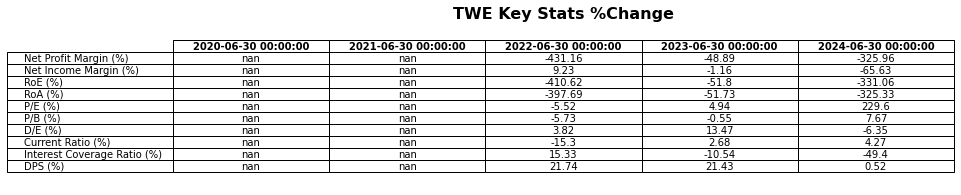

In [42]:
# Create the plot for the table
fig, ax = plt.subplots(figsize=(14, 3))  # Adjust the figure size as needed
ax.axis('tight')
ax.axis('off')

# Create a table in the plot
table = ax.table(cellText=interested_ticker_key_interested_stats_pct_change.T.values,
                 colLabels=interested_ticker_key_interested_stats_pct_change.T.columns,
                 rowLabels=interested_ticker_key_interested_stats_pct_change.T.index,
                 cellLoc='center', loc='center')

# Bold the header row
for key, cell in table.get_celld().items():
    if key[0] == 0:  # This selects the header row
        cell.set_text_props(fontweight='bold')

# Set the title with bold font
plt.title(f"{TICKER} Key Stats %Change", fontsize=16, fontweight='bold')

# Save the plot as an image
plt.savefig(
    f'../outputs/{TICKER}_interested_ticker_key_interested_stats_pct_change.png', bbox_inches='tight', dpi=300)

# Optionally display the plot
plt.show()

In [43]:
raw_stats_dict = dict()
object_dict = dict()

for ticker in comparable_ASX_tickers_dict['list']:
    ticker = ticker.split('.')[0]
    print('\n', ticker)
    raw_stats, key_interested_stats, key_interested_stats_pct_change, object = get_fundemental_dfs(
        first_end_of_quarter, historical_prices_dict, ticker)

    raw_stats_dict[ticker] = raw_stats
    object_dict[ticker] = object


 EDV


In [44]:
interpolated_financial_stats_dict = {}
for key in raw_stats_dict.keys():
    interpolated_financial_stats = interpolate_financial_stats(
        raw_stats_dict, key)
    interpolated_financial_stats_dict[key] = interpolated_financial_stats

In [45]:
interested_dates = [pd.to_datetime(
    dt.strftime('%Y-%m')) for dt in interested_ticker_key_interested_stats_pct_change.index]

In [46]:
agg_interpolated_financial_stats_df_dict = {}
for key in interpolated_financial_stats_dict:
    agg_interpolated_financial_stats_df = agg_interpolated_financial_stats(
        interpolated_financial_stats_dict[key], interested_dates)
    agg_interpolated_financial_stats_df_dict[key] = agg_interpolated_financial_stats_df

In [47]:
key_interested_stats_dict = {}
key_interested_stats_pct_change_dict = {}

for key in agg_interpolated_financial_stats_df_dict:
    stock_fundementals = process_stock_fundementals(
        agg_interpolated_financial_stats_df_dict[key], object_dict[key], first_end_of_quarter, historical_prices_dict, key)

    key_interested_stats = get_key_interested_stats(stock_fundementals)

    key_interested_stats_pct_change = get_key_interested_stat_pct_change(
        key_interested_stats
    )

    key_interested_stats_dict[key] = key_interested_stats
    key_interested_stats_pct_change_dict[key] = key_interested_stats_pct_change

In [48]:
weighted_GICS_key_interested_stats = get_weighted_financials(
    key_interested_stats_dict, same_gics_industry_weight_dict)

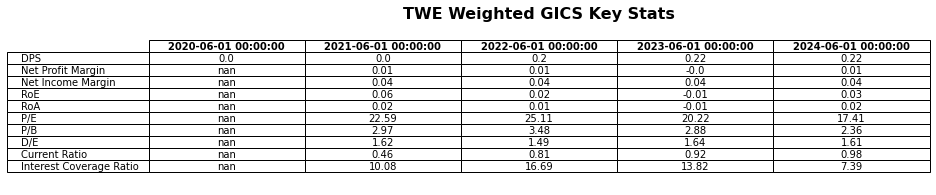

In [49]:
# Create the plot for the table
fig, ax = plt.subplots(figsize=(14, 3))  # Adjust the figure size as needed
ax.axis('tight')
ax.axis('off')

# Create a table in the plot
table = ax.table(cellText=weighted_GICS_key_interested_stats.T.values,
                 colLabels=weighted_GICS_key_interested_stats.T.columns,
                 rowLabels=weighted_GICS_key_interested_stats.T.index,
                 cellLoc='center', loc='center')

# Bold the header row
for key, cell in table.get_celld().items():
    if key[0] == 0:  # This selects the header row
        cell.set_text_props(fontweight='bold')

# Set the title with bold font
plt.title(f"{TICKER} Weighted GICS Key Stats",
          fontsize=16, fontweight='bold')

# Save the plot as an image
plt.savefig(
    f'../outputs/{TICKER}_weighted_GICS_key_interested_stats.png', bbox_inches='tight', dpi=300)

# Optionally display the plot
plt.show()

In [50]:
weighted_GICS_key_interested_stats

,DPS,Net Profit Margin,Net Income Margin,RoE,RoA,P/E,P/B,D/E,Current Ratio,Interest Coverage Ratio
2020-06-01,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-06-01,0.00,0.01,0.04,0.06,0.02,22.59,2.97,1.62,0.46,10.08
2022-06-01,0.20,0.01,0.04,0.02,0.01,25.11,3.48,1.49,0.81,16.69
2023-06-01,0.22,-0.00,0.04,-0.01,-0.01,20.22,2.88,1.64,0.92,13.82
2024-06-01,0.22,0.01,0.04,0.03,0.02,17.41,2.36,1.61,0.98,7.39


In [51]:
# can delete
interested_ticker_key_interested_stats

,Net Profit Margin,Net Income Margin,RoE,RoA,P/E,P/B,D/E,Current Ratio,Interest Coverage Ratio,DPS
2020-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-06-30,-0.01,0.10,-0.01,-0.01,30.73,2.14,0.43,2.34,6.43,0.23
2022-06-30,0.03,0.11,0.02,0.02,29.04,2.02,0.44,1.98,7.41,0.28
2023-06-30,0.02,0.11,0.01,0.01,30.47,2.01,0.50,2.04,6.63,0.34
2024-06-30,-0.04,0.04,-0.02,-0.02,100.43,2.16,0.47,2.12,3.35,0.34


# TODO: need change. 

In [52]:
weighted_GICS_key_interested_stats_pct_change = get_weighted_financials(
    key_interested_stats_pct_change_dict, same_gics_industry_weight_dict)

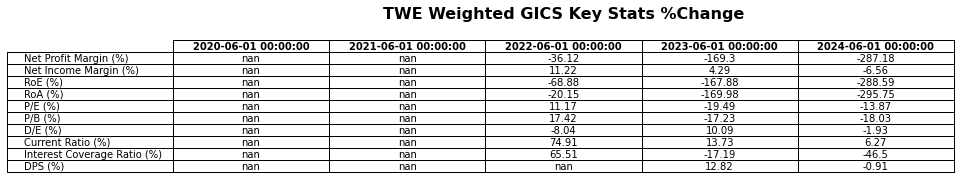

In [53]:
# Create the plot for the table
fig, ax = plt.subplots(figsize=(14, 3))  # Adjust the figure size as needed
ax.axis('tight')
ax.axis('off')

# Create a table in the plot
table = ax.table(cellText=weighted_GICS_key_interested_stats_pct_change.T.values,
                 colLabels=weighted_GICS_key_interested_stats_pct_change.T.columns,
                 rowLabels=weighted_GICS_key_interested_stats_pct_change.T.index,
                 cellLoc='center', loc='center')

# Bold the header row
for key, cell in table.get_celld().items():
    if key[0] == 0:  # This selects the header row
        cell.set_text_props(fontweight='bold')

# Set the title with bold font
plt.title(f"{TICKER} Weighted GICS Key Stats %Change",
          fontsize=16, fontweight='bold')

# Save the plot as an image
plt.savefig(
    f'../outputs/{TICKER}_weighted_GICS_key_interested_stats_pct_change.png', bbox_inches='tight', dpi=300)

# Optionally display the plot
plt.show()

In [54]:
weighted_GICS_key_interested_stats_pct_change

,Net Profit Margin (%),Net Income Margin (%),RoE (%),RoA (%),P/E (%),P/B (%),D/E (%),Current Ratio (%),Interest Coverage Ratio (%),DPS (%)
2020-06-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-06-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-06-01,-36.12,11.22,-68.88,-20.15,11.17,17.42,-8.04,74.91,65.51,NaN
2023-06-01,-169.30,4.29,-167.88,-169.98,-19.49,-17.23,10.09,13.73,-17.19,12.82
2024-06-01,-287.18,-6.56,-288.59,-295.75,-13.87,-18.03,-1.93,6.27,-46.50,-0.91


In [55]:
# can remove
interested_ticker_key_interested_stats_pct_change

,Net Profit Margin (%),Net Income Margin (%),RoE (%),RoA (%),P/E (%),P/B (%),D/E (%),Current Ratio (%),Interest Coverage Ratio (%),DPS (%)
2020-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-06-30,-431.16,9.23,-410.62,-397.69,-5.52,-5.73,3.82,-15.30,15.33,21.74
2023-06-30,-48.89,-1.16,-51.80,-51.73,4.94,-0.55,13.47,2.68,-10.54,21.43
2024-06-30,-325.96,-65.63,-331.06,-325.33,229.60,7.67,-6.35,4.27,-49.40,0.52
